## Import Libraries

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## See the Yahoo Finance Ticker for Your Stock Symbol

In [2]:
stock_symbol = 'NZDUSD=X'

### Last 5 Years Data With Interval of 1 Day

In [3]:
data = yf.download(tickers=stock_symbol, period='5y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-05,0.694850,0.703448,0.694420,0.694850,0.694850,0
2022-04-06,0.694768,0.696748,0.692612,0.694768,0.694768,0
2022-04-07,0.691152,0.692042,0.688320,0.691152,0.691152,0
2022-04-08,0.688492,0.689218,0.682412,0.688492,0.688492,0
2022-04-11,0.684838,0.685683,0.683527,0.683901,0.683901,0


### Use Open Prices

In [6]:
opn = data['Open']

### Plot Open Value Prices

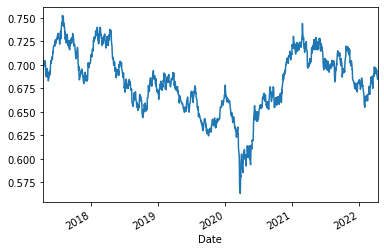

In [7]:
opn.plot()

In [8]:
ds = opn.values
ds

array([0.69633031, 0.69565219, 0.69935936, ..., 0.69115192, 0.68849182,
       0.6848377 ])

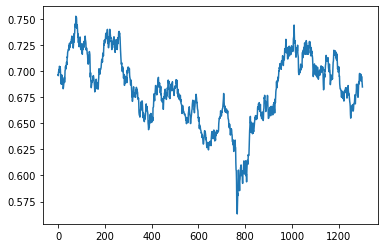

In [9]:
plt.plot(ds)

### Using MinMaxScaler for Normalizing Data Between 0 & 1

In [10]:
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [11]:
len(ds_scaled), len(ds)

(1302, 1302)

### Defining Test and Train Data Sizes

In [12]:
train_size = int(len(ds_scaled)*0.7)
test_size = len(ds_scaled) - train_size

In [13]:
train_size,test_size

(911, 391)

### Split Data Between Train and Test

In [14]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [15]:
len(ds_train),len(ds_test)

(911, 391)

### Creating Dataset in Time Series for LSTM Model

In [16]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

### Taking n Days Price As One Record for Training

In [17]:
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [18]:
X_train.shape, y_train.shape

((810, 100), (810,))

In [19]:
X_test.shape, y_test.shape

((290, 100), (290,))

### Reshaping Data to Fit Into LSTM Model

In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### Creating LSTM Model Using Keras

In [21]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### Training Model With Adam Optimizer And Aqured Error Loss Function

In [22]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train, y_train,validation_data=[X_test,y_test],epochs=100,batch_size=64)

Train on 810 samples, validate on 290 samples
Epoch 1/100
810/810 [==============================] - 90s 111ms/sample - loss: 0.1137 - val_loss: 0.0150
Epoch 2/100
810/810 [==============================] - 15s 19ms/sample - loss: 0.0131 - val_loss: 0.0048
Epoch 3/100
810/810 [==============================] - 11s 14ms/sample - loss: 0.0074 - val_loss: 0.0072
Epoch 4/100
810/810 [==============================] - 10s 12ms/sample - loss: 0.0053 - val_loss: 0.0042
Epoch 5/100
810/810 [==============================] - 10s 12ms/sample - loss: 0.0046 - val_loss: 0.0029
Epoch 6/100
810/810 [==============================] - 10s 13ms/sample - loss: 0.0040 - val_loss: 0.0028
Epoch 7/100
810/810 [==============================] - 10s 13ms/sample - loss: 0.0036 - val_loss: 0.0029
Epoch 8/100
810/810 [==============================] - 11s 13ms/sample - loss: 0.0034 - val_loss: 0.0028
Epoch 9/100
810/810 [==============================] - 11s 14ms/sample - loss: 0.0033 - val_loss: 0.0028
Epoch 10

### Plotting Loss

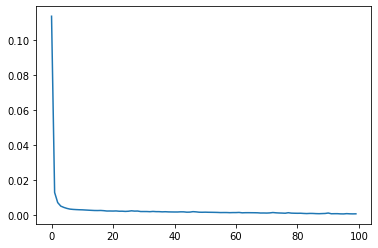

In [23]:
loss = model.history.history['loss']
plt.plot(loss)

### Predicting On Train And Test Data

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

### Inverse transform to Get Actual Value

In [25]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

### Comparing Using Visuals

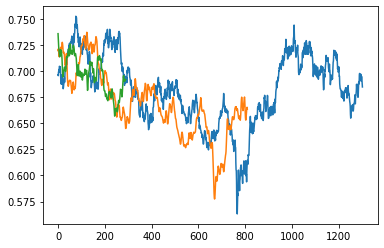

In [26]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [27]:
type(train_predict)

numpy.ndarray

In [28]:
test = np.vstack((train_predict,test_predict))

### Combining The Predicted Data To Create Uniform Data Visualization

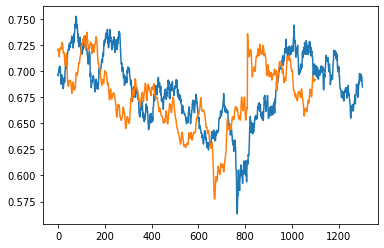

In [29]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [30]:
len(ds_test)

391

### Getting The Last 100 Days Records

In [31]:
fut_inp = ds_test[291:]

In [32]:
fut_inp = fut_inp.reshape(1,-1)

In [33]:
tpm_inp = list(fut_inp)

In [34]:
fut_inp.shape

(1, 100)

### Creating List of The Last n data

In [35]:
tmp_inp = tpm_inp[0].tolist()

### predicting next 30 Days price using the current data
### It Will In Sliding Window Manner (algorithm) With Stride 1

In [36]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)

[[0.6552431583404541], [0.6466822624206543], [0.6425378918647766], [0.6404238939285278], [0.6391297578811646], [0.6380465030670166], [0.6368050575256348], [0.6351495981216431], [0.6329120993614197], [0.6300134062767029], [0.6264581084251404], [0.6223208904266357], [0.6177263259887695], [0.6128255724906921], [0.6077742576599121], [0.6027133464813232], [0.5977550148963928], [0.5929759740829468], [0.5884150266647339], [0.5840765833854675], [0.5799371600151062], [0.5759546756744385], [0.5720770955085754], [0.5682513117790222], [0.564428985118866], [0.5605724453926086], [0.5566563606262207], [0.5526685118675232], [0.5486088991165161], [0.5444874167442322]]


In [37]:
len(ds_scaled)

1302

### creating A Dummy Plane To Plot Graph One After Another

In [38]:
plot_new = np.arange(1,101)
plot_pred = np.arange(101,131)

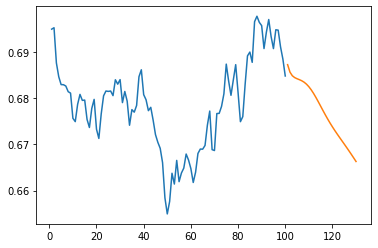

In [39]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1202:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [40]:
ds_new = ds_scaled.tolist()

In [41]:
len(ds_new)

1302

### Extend Helps Us Fill The Missing Values With Approx Value

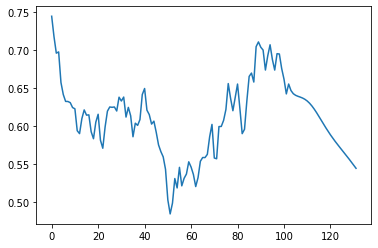

In [42]:
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

### Creating Final Data For Plotting

In [43]:
final_graph = normalizer.inverse_transform(ds_new).tolist()

### Plotting Final Results With Predicted Value After 30 Days

In [1]:
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} Prediction of Next Month open".format(stock_symbol))

plt.legend(color='gray')

NameError: name 'plt' is not defined